<a href="https://colab.research.google.com/github/jeanmhuang/Daily-Quant-Notes/blob/main/2025_09_08_monte_carlo_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 2025-09-08 — Monte Carlo Demo

This notebook contains three quick Monte Carlo demos for my **Daily-Quant-Notes** repo:

1. **Simple Random Walk** — simulate multiple paths and summarize distribution properties.  
2. **Geometric Brownian Motion (GBM)** — simulate price paths and compare Monte Carlo vs analytical expectation.  
3. **European Call Option Pricing** — price via Monte Carlo with a 95% confidence interval and compare with Black–Scholes (closed form).



In [1]:

import numpy as np
import matplotlib.pyplot as plt
from math import erf, sqrt, log, exp

# Reproducibility
np.random.seed(42)

# For nicer plots in notebooks
%matplotlib inline



## 1) Simple Random Walk

We simulate `n_paths` symmetric random walks with step size `±1`.  
The Central Limit Theorem suggests the terminal distribution tends toward normal with mean 0 and variance `T`.


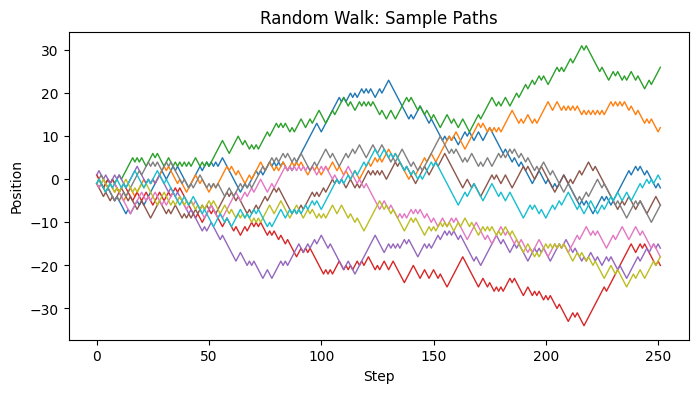

Terminal mean: 0.240
Terminal std:  15.590  (theoretical ~ sqrt(T) = 15.875)


In [2]:

T = 252            # number of steps (e.g., trading days in a year)
n_paths = 50       # number of simulated paths
step_choices = np.array([-1, 1])

steps = np.random.choice(step_choices, size=(n_paths, T))
rw_paths = steps.cumsum(axis=1)

# Plot a handful of paths
plt.figure(figsize=(8, 4))
for i in range(min(n_paths, 10)):
    plt.plot(rw_paths[i], linewidth=1)
plt.title("Random Walk: Sample Paths")
plt.xlabel("Step")
plt.ylabel("Position")
plt.show()

terminal = rw_paths[:, -1]
print(f"Terminal mean: {terminal.mean():.3f}")
print(f"Terminal std:  {terminal.std(ddof=1):.3f}  (theoretical ~ sqrt(T) = {np.sqrt(T):.3f})")



## 2) Geometric Brownian Motion (GBM)

We simulate GBM using the discretization:

\[ S_{t+\Delta t} = S_t \cdot \exp\Big((\mu - \tfrac{1}{2}\sigma^2)\Delta t + \sigma\sqrt{\Delta t}\,Z\Big) \]

**Analytical expectation:** \(\mathbb{E}[S_T] = S_0 e^{\mu T}\).


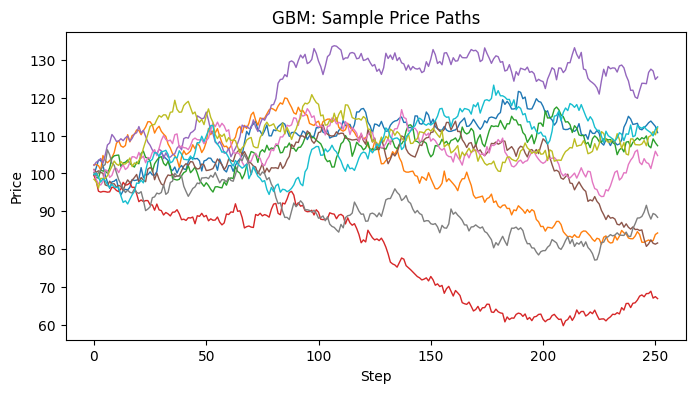

Monte Carlo E[S_T]: 107.870
Analytical  E[S_T]: 108.329
Absolute error: 0.459


In [3]:

S0 = 100.0
mu = 0.08          # drift
sigma = 0.2        # volatility
T_years = 1.0
steps = 252
dt = T_years / steps
paths = 2000

log_increments = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.randn(paths, steps)
log_paths = np.cumsum(log_increments, axis=1)
S_paths = S0 * np.exp(log_paths)

# Plot a few sample paths
plt.figure(figsize=(8, 4))
for i in range(10):
    plt.plot(S_paths[i], linewidth=1)
plt.title("GBM: Sample Price Paths")
plt.xlabel("Step")
plt.ylabel("Price")
plt.show()

S_T = S_paths[:, -1]
mc_mean = S_T.mean()
analytical = S0 * np.exp(mu * T_years)
print(f"Monte Carlo E[S_T]: {mc_mean:.3f}")
print(f"Analytical  E[S_T]: {analytical:.3f}")
print(f"Absolute error: {abs(mc_mean - analytical):.3f}")



## 3) European Call Option Pricing

Price a European call via Monte Carlo and compare with Black–Scholes closed form.

**Monte Carlo estimator:**  
\[ C \approx e^{-rT} \cdot \frac{1}{N}\sum_{i=1}^N \max(S_T^{(i)} - K, 0) \]

**Black–Scholes:**  
\[ C = S_0\Phi(d_1) - K e^{-rT}\Phi(d_2) \]  
with  
\[ d_{1,2} = \frac{\ln(S_0/K) + (r \pm \tfrac{1}{2}\sigma^2)T}{\sigma\sqrt{T}} \]


In [4]:

def norm_cdf(x):
    # Using error function for normal CDF to avoid external deps
    return 0.5 * (1.0 + erf(x / sqrt(2.0)))

def black_scholes_call(S0, K, r, sigma, T):
    d1 = (log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return S0 * norm_cdf(d1) - K * exp(-r * T) * norm_cdf(d2)

# Parameters
S0 = 100.0
K = 100.0
r = 0.03
sigma = 0.2
T_years = 1.0
N = 200_000  # paths for pricing

# Simulate terminal price directly for GBM
Z = np.random.randn(N)
S_T = S0 * np.exp((r - 0.5 * sigma**2) * T_years + sigma * sqrt(T_years) * Z)

payoffs = np.maximum(S_T - K, 0.0)
discounted = np.exp(-r * T_years) * payoffs
mc_price = discounted.mean()
mc_std = discounted.std(ddof=1)
stderr = mc_std / np.sqrt(N)

# 95% CI
ci_low = mc_price - 1.96 * stderr
ci_high = mc_price + 1.96 * stderr

bs_price = black_scholes_call(S0, K, r, sigma, T_years)

print(f"Monte Carlo call: {mc_price:.4f}")
print(f"95% CI: [{ci_low:.4f}, {ci_high:.4f}] (stderr={stderr:.6f})")
print(f"Black–Scholes: {bs_price:.4f}")


Monte Carlo call: 9.4340
95% CI: [9.3721, 9.4958] (stderr=0.031565)
Black–Scholes: 9.4134



### Wrap‑Up

- Random walk terminal distribution width grows as \(\sqrt{T}\).  
- GBM Monte Carlo mean should align with \(S_0 e^{\mu T}\).  
- Monte Carlo option price should lie near the Black–Scholes value, with uncertainty quantified by the confidence interval.


